In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

import os
import io
import sys

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras import utils

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Pour ignorer les warning/alertes
import warnings
warnings.filterwarnings("ignore")

# Encoding des trois classes
ENCODING = {'COVID-19': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}

# Dossier contenant les images
FOLDERS = ENCODING.keys()

# Dossier racine contenant les sous dossiers
BASE_DIRECTORY = '../Data'

# Noms des dossiers contentant l'ensemble des images des plots ainsi qu'un text file du model.summary, les métriques sauv sous
CNN_ARCHITECTURE_1 = 'cnn_architecture_1'
if not os.path.exists(CNN_ARCHITECTURE_1):
    os.makedirs(CNN_ARCHITECTURE_1)

CNN_ARCHITECTURE_2 = 'cnn_architecture_2'
if not os.path.exists(CNN_ARCHITECTURE_2):
    os.makedirs(CNN_ARCHITECTURE_2)

In [12]:
NB_im = []
for folder in FOLDERS:
    path_to_folder = f'{BASE_DIRECTORY}/{folder}'
    NB_im.append(len(os.listdir(path_to_folder)))

In [13]:
def im_resize_256(img):
    """
    Cette fonction lit une image et retourne la même image avec une résolution de 256 X 256
    """
    if img.shape == (256,256):
        img_ret = img
    else :
        img_ret = cv2.resize(img, dsize = (256,256))
    return img_ret

In [14]:
# Vecteur des noms d'images
Vnoms = []
# Vecteur des types
Vtypes = []
# Vecteur des images
Vim = np.empty((np.array(NB_im).sum(), 256*256))

### Remplissage des vecteurs

j = 0
# Parcourir les folders( on en a trois)
for type_im, nb in zip(FOLDERS,NB_im):
    # Parcourir les images de chaque folder, nb c'est le nombre d'image de chaque folder.
    for i in range(1,nb+1):
        # Type de l'image 
        Vtypes.append(type_im)
        # Construire le nom de l'image
        nom = "%s (%s).png" %(type_im,i)
        Vnoms.append(nom)
        # Chemin de l'image
        path_im = f'{BASE_DIRECTORY}/{type_im}/{nom}'
        # Lecture de l'image
        img_gray = cv2.imread(path_im, cv2.IMREAD_GRAYSCALE) 
        # Transformer l'image en une image de taille 256 X 256
        img_gray = im_resize_256(img_gray).reshape(256*256)
        # Inserer l'image dans le vecteur des images (Vim)
        Vim[j] = img_gray
        j = j+1

In [15]:
df = pd.DataFrame(data = Vim, index = Vnoms)
df = df.astype('int')
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
COVID-19 (1).png,175,11,0,0,0,0,0,0,0,0,...,0,5,22,8,0,1,1,0,20,159
COVID-19 (2).png,15,15,17,25,25,25,21,14,13,9,...,26,38,57,110,111,113,69,105,105,83
COVID-19 (3).png,144,145,145,142,142,141,141,140,140,140,...,199,200,197,196,197,199,197,195,197,176
COVID-19 (4).png,135,132,130,129,129,129,128,128,128,127,...,175,173,172,170,168,166,165,163,167,161
COVID-19 (5).png,1,0,0,0,0,0,0,0,0,0,...,30,23,17,1,0,0,0,2,21,49
COVID-19 (6).png,39,48,40,36,29,14,9,10,14,17,...,12,10,10,10,10,10,10,10,10,10
COVID-19 (7).png,4,7,6,6,6,6,6,6,6,6,...,4,4,4,3,25,6,4,4,3,3
COVID-19 (8).png,3,5,5,5,5,5,5,5,5,5,...,3,3,3,2,24,5,3,3,2,2
COVID-19 (9).png,0,0,3,3,4,5,4,5,6,5,...,12,12,11,11,10,10,10,5,0,0
COVID-19 (10).png,0,0,13,103,89,77,61,61,67,61,...,65,59,52,44,34,16,0,0,0,0


# Modèles Réseaux de Neurones

Dans un premier temps, on doit récupérer la data représentant les images sous forme de numpy array. Ainsi que la target qu'on 
encodera on utilisant le dictionnaire ENCODING

In [16]:
data = df.to_numpy()
data = data.reshape(-1, 256, 256, 1)
data.shape

(3829, 256, 256, 1)

In [18]:
target = pd.Series(Vtypes).replace(ENCODING)
target.shape

(3829,)

In [20]:
"""
Pour markdown, Stocker le modèle en local et permet d'exporter le model summary au format text
"""
def save_model(model, folder_to_store):
    # Récuperer le contenu summary du modèle et le Stocker dans un fichier text
    stream = io.StringIO()
    # récupérer le contenu du summary dans la variable stream
    model.summary(print_fn=lambda x: stream.write(x + '\n'))
    # extraire le texte du stream
    summary = stream.getvalue()
    stream.close()
    export_to_text_file(summary, 'summary', folder_to_store)
    
    # Stocker le modèle en local pour une utilisation ultérieur (Démo...)
    model.save(f'./{folder_to_store}')
    

"""
Stocker le contenu au format fichier text.
"""
def export_to_text_file(content, name, folder_to_store):
    #créer un fichier sous folder to store avec le nom name extension txt, en mode write pour pouvoir ecrir
    file = open(f'{folder_to_store}/{name}.txt', "w")
    file.write(content)
    file.close()

In [21]:
"""
Evaluer un Modèle: Matrice de Confusion, Classification Report, Plot des accuracy. Elle prend les paramèters suivants:

model : Le modèle qu'on évalue
x_valid : Le dataset de test / validation
y_valid : Le target du test / validation
title : Le titre qu'on souhaite donner
history : Le resultat obtenu lors du fit du model
epoch : Le nombre d'Epoch utilisé pour le train du modèle
directory_to_store : Le dossier où stocker les plots, modèle

"""
def evaluate(model, x_valid, y_valid, title, history, epoch, directory_to_store):
  # Calculer la prediction sur dataset de test/validation
  y_pred = model.predict_classes(x_valid)
  #  Contruire la Matrice de Confusion
  cm = confusion_matrix(y_valid, y_pred)
  # Plot de la Matrice de confusion  
  plt.figure(figsize=(14,6))
  plt.title('Matrice de Confusion')
  sns.heatmap(cm, 
            cmap="Blues", 
            linecolor='black', 
            linewidth = 1, 
            annot = True, 
            fmt='',
            #xticklabels=['Viral Pneumonia','NORMAL', 'COVID-19'], 
            xticklabels=ENCODING.keys(),
            yticklabels=ENCODING.keys()  
            #yticklabels = ['Viral Pneumonia','NORMAL', 'COVID-19']  
  )
  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits')
  # Exporter plot en PNG
  plt.savefig(f'./{directory_to_store}/matrice_confusion.png')


  # Afficher le classification Report
  print('Classification Report : ')
  report = classification_report(y_true=y_valid, y_pred = y_pred, target_names=ENCODING.keys())
  print(report)
  export_to_text_file(report, 'classification_report', directory_to_store)
  
  # Ploter accuracy du training et de validation 
  plt.figure(figsize=(15,6))
  plt.subplot(1,2,1)
  plt.plot(np.arange(1, epoch+1), history.history['accuracy'])
  plt.plot(np.arange(1, epoch+1), history.history['val_accuracy'])
  plt.legend(["Training Accuracy", "Validation Accuracy"])
  plt.title("Training et Validation Accuracy")
  plt.grid()
  plt.xlim([1, epoch]);
  plt.xlabel("Epoch");

  plt.subplot(1,2,2)
  plt.plot(np.arange(1,epoch+1), history.history['loss'])
  plt.plot(np.arange(1,epoch+1), history.history['val_loss'])
  plt.legend(["Training loss", "Validation loss"])
  plt.title("Training et Validation loss")
  plt.grid()
  plt.xlim([1, epoch]);
  plt.xlabel("Epoch");
  plt.savefig(f'./{directory_to_store}/loss.png')  

  # Stocker le modèle 
  save_model(model, directory_to_store)

### Split en dataset de Test et de Train

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=42)

## Normalisation

In [24]:
X_train = X_train/255
X_test = X_test/255

## CNN SparseCategoricalCrossentropy 

Pour le cas de l'utilisation de Sparse comme loss function, on n'a pas besoin de transformer le target en vecteur categoriel
Documentation: https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

In [25]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=3, activation="relu", input_shape=[256, 256, 1]))
model.add(MaxPool2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add( Dense(units=64, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(units=3, activation='softmax'))

# Afficher un Summary du Modèle utilisé
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                7872576   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [26]:
# Learning rate: 0.01 avec Loss function de type sparse, on utilise la metrique accuracy
epochs=9
model.compile(optimizer=Adam(learning_rate = 0.01),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history = model.fit(x = X_train, y = y_train, epochs=epochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/9
96/96 [==============================] - 195s 2s/step - loss: 10.0064 - accuracy: 0.5706 - val_loss: 0.5681 - val_accuracy: 0.7977
Epoch 2/9
96/96 [==============================] - 190s 2s/step - loss: 0.6059 - accuracy: 0.7666 - val_loss: 0.6403 - val_accuracy: 0.7037
Epoch 3/9
96/96 [==============================] - 189s 2s/step - loss: 0.6501 - accuracy: 0.7090 - val_loss: 0.4626 - val_accuracy: 0.8342
Epoch 4/9
96/96 [==============================] - 189s 2s/step - loss: 0.4749 - accuracy: 0.8259 - val_loss: 0.3576 - val_accuracy: 0.8747
Epoch 5/9
96/96 [==============================] - 189s 2s/step - loss: 0.3075 - accuracy: 0.8860 - val_loss: 0.3241 - val_accuracy: 0.8903
Epoch 6/9
96/96 [==============================] - 190s 2s/step - loss: 0.1945 - accuracy: 0.9275 - val_loss: 0.4123 - val_accuracy: 0.8903
Epoch 7/9
96/96 [==============================] - 188s 2s/step - loss: 0.1588 - accuracy: 0.9493 - val_loss: 0.2746 - val_accuracy: 0.8969
Epoch 8/9
96/96 [==

### Evaluation du Modèle

Classification Report : 
                 precision    recall  f1-score   support

       COVID-19       0.95      0.89      0.92       245
         NORMAL       0.85      0.97      0.90       269
Viral Pneumonia       0.92      0.84      0.88       252

       accuracy                           0.90       766
      macro avg       0.91      0.90      0.90       766
   weighted avg       0.90      0.90      0.90       766

INFO:tensorflow:Assets written to: ./cnn_architecture_1\assets


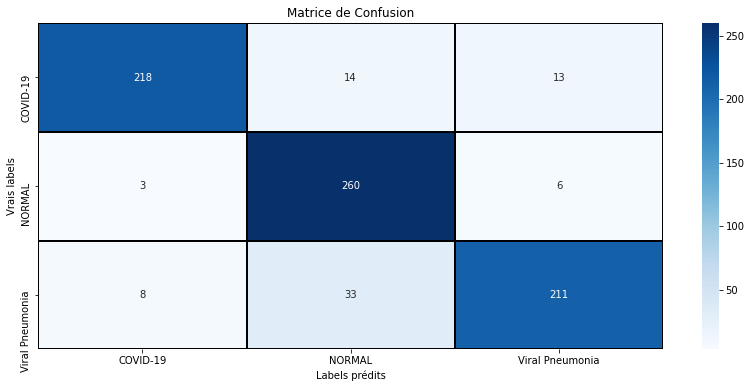

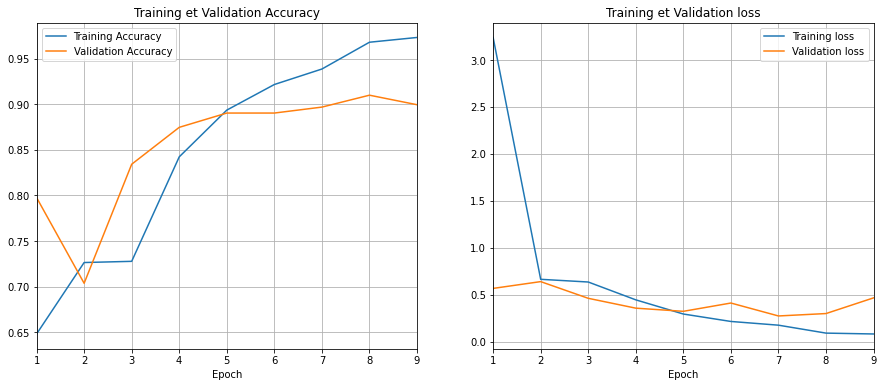

In [27]:
evaluate(model, X_test, y_test, 'CNN Architecture (A)', history, epochs, CNN_ARCHITECTURE_1)

Vu que ce premier modèle n'est pas satisfaisant, après multiples essais, nous décidons de partir sur le modèle ci-dessous

## CNN avec CategoricalCrossentropy

Dans ce second modèle, on a mis à jour l'architecture du modèle avec plus de couches, ainsi qu'un learning rate varibale. Ici on aura besoin de transformer notre target en vecteur categoriel.

Learning Rate Varible: https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/
CategoricalCrossentropy : https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy

On Utilise en sortie la fonction d'Activation Softmax. Car on est dans une classification multi classes. voir https://keras.io/api/layers/activations/

In [33]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", input_shape=[256, 256, 1]))
model.add(MaxPool2D(pool_size=2, padding="same"))
model.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(units=32, activation ="relu"))
model.add(Dense(units=16, activation ="relu"))
model.add(Dense(units=3, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8388672   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [34]:
# Compiler le modèle en utilisant CategoricalCrossentropy comme loss function ainsi qu'un learning rate variable
initial_learning_rate = 0.01
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=6000,
    decay_rate=0.95,
    staircase=True)
model.compile(optimizer=Adam(learning_rate = lr_schedule),
              loss = CategoricalCrossentropy(),
              metrics=['accuracy'])

In [35]:
# CategoricalCrossentropy nécessite que la target soit catégorielle 
y_train_categorial = utils.to_categorical(y_train)
y_test_categorial = utils.to_categorical(y_test)

# Fit le modèle
epochs = 10
history = model.fit(X_train, y_train_categorial, epochs=epochs, verbose=1, validation_data=(X_test, y_test_categorial))

Epoch 1/10
96/96 [==============================] - 183s 2s/step - loss: 1.8918 - accuracy: 0.5287 - val_loss: 0.5588 - val_accuracy: 0.7533
Epoch 2/10
96/96 [==============================] - 177s 2s/step - loss: 0.5080 - accuracy: 0.7896 - val_loss: 0.4485 - val_accuracy: 0.8081
Epoch 3/10
96/96 [==============================] - 181s 2s/step - loss: 0.4552 - accuracy: 0.8162 - val_loss: 0.4127 - val_accuracy: 0.8512
Epoch 4/10
96/96 [==============================] - 181s 2s/step - loss: 0.3622 - accuracy: 0.8711 - val_loss: 0.3642 - val_accuracy: 0.8838
Epoch 5/10
96/96 [==============================] - 182s 2s/step - loss: 0.3253 - accuracy: 0.8720 - val_loss: 0.3011 - val_accuracy: 0.8825
Epoch 6/10
96/96 [==============================] - 184s 2s/step - loss: 0.2449 - accuracy: 0.9073 - val_loss: 0.3999 - val_accuracy: 0.8708
Epoch 7/10
96/96 [==============================] - 185s 2s/step - loss: 0.2088 - accuracy: 0.9295 - val_loss: 0.4103 - val_accuracy: 0.8603
Epoch 8/10
96

### Evaluation du Modèle

Classification Report : 
                 precision    recall  f1-score   support

       COVID-19       0.99      0.90      0.94       245
         NORMAL       0.82      0.94      0.87       269
Viral Pneumonia       0.91      0.84      0.87       252

       accuracy                           0.89       766
      macro avg       0.90      0.89      0.90       766
   weighted avg       0.90      0.89      0.90       766

INFO:tensorflow:Assets written to: ./cnn_architecture_2\assets


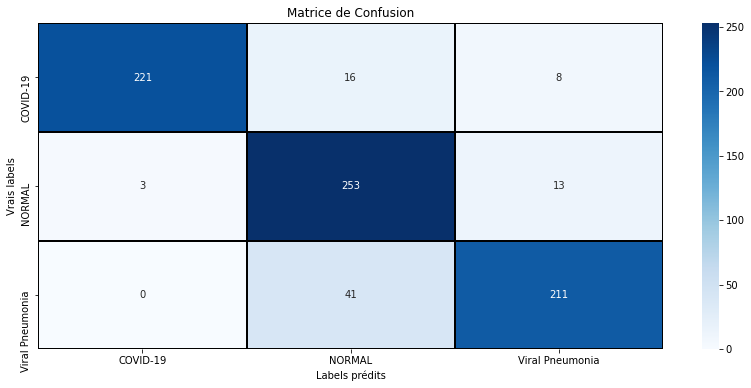

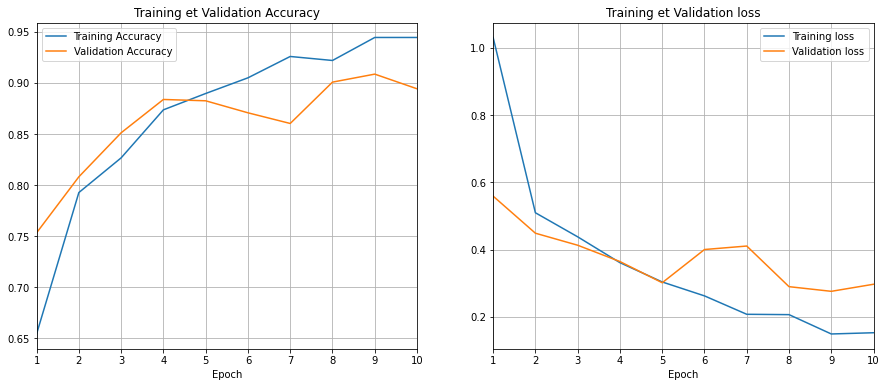

In [36]:
evaluate(model, X_test, y_test, 'CNN Architecture (B)', history, epochs, CNN_ARCHITECTURE_2)